# BI-Projekt
## Aufgabe 5

***5. Sinkt die Wahrscheinlichkeit zu siegen, wenn das vorhergehende Spiel eines Spielers besonders lange gedauert hat?***

Bei dieser Frage muss erstmal definiert werden, was ein "besonders langes" Spiel überhaupt ist. Verglichen mit zum Beispiel Fußball wird Tennis nicht nach Zeit gespielt sondern es muss eine bestimmte Anzahl an Sätzen gewonnen werden. Hat man diese Zahl der Gewinnsätze erreicht, so endet das Spiel. In der "atp_matches_till_2022.csv" sehen wir einige Features, die eventuell besonders Hinweise liefern können auf die Länge eines Spieles.

In [8]:
#Relevante module
import plotly.express as px
import pandas as pd
import numpy as np
import missingno as mn

df_matches = pd.read_csv("data/atp_matches_till_2022.csv")
df_matches.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size               int64
tourney_level          object
tourney_date            int64
match_num               int64
winner_id               int64
winner_seed           float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id                int64
loser_seed            float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of                 int64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms   

Interessant scheinen die Features: score, best_of und minutes.  
- score  
Wenn man sich mit den Tennisregeln etwas stärker beschäftigt, dann stellt man aber fest das ein Satz endet wenn ein Spieler zuerst 6 Aufschlagspiele gewinnt mit der Voraussetzung dieser hat einen Vorsprung von mindestens zwei Aufschlagspielen gegenüber des Gegners. Damit gibt es die Möglichkeit, dass tatsächlich ein Satz der mit 6:1 gewonnen wurde, länger dauert als ein Satz der mit 7:5 gewonnen wurde (Was aber nicht die Regel sein sollte.). Damit ist die score nicht ganz geeignet.  
- best_of  
Das nächste Feature best_of sagt uns die maximale Anzahl von Sätzen die gespielt wird(und auch die Mindestzahl).


In [3]:
#Welche best_of gibt es überhaupt?
df_matches.best_of.unique()

array([3, 5, 1], dtype=int64)

 Zum Beispiel wird bei einem best_of 5 erwartet, dass mindestens 3 Sätze gespielt werden.  
 Es werden ein paar Zeilen zur Überprüfung ausgegeben, ob die Scores auch zum best_of passen:

In [6]:
display(df_matches.loc[df_matches['best_of'].eq(5)][['score']].head(10))

,score
31,6-1 6-4 6-4
32,6-3 6-2 0-6 6-3
33,11-9 9-11 6-4 6-3
34,6-1 4-6 10-8 6-3
35,6-2 8-6 6-2
36,6-4 8-10 6-4 6-4
37,9-7 6-4 6-4
38,6-4 8-6 8-6
39,6-4 6-4 6-2
40,6-4 6-3 6-2


Es scheint zu passen auf den ersten Blick.  
- minutes  
Das am meisten geeignetste Feature ist aber offensichtlich minutes, der wie der Name verrät die Dauer eines Spiels(Matches) in Minuten angibt. Aber es darf nicht Blind nur auf die Minuten geguckt werden denn wir sollten beachten, ob ein Spiel für ein best_of 5 oder ein best_of 3 besonders lange gedauert hat. Das Feature minutes hat aber einen kleinen Makel wenn auf die Null-Werte geschaut wird der relevanten Features:

<Axes: >

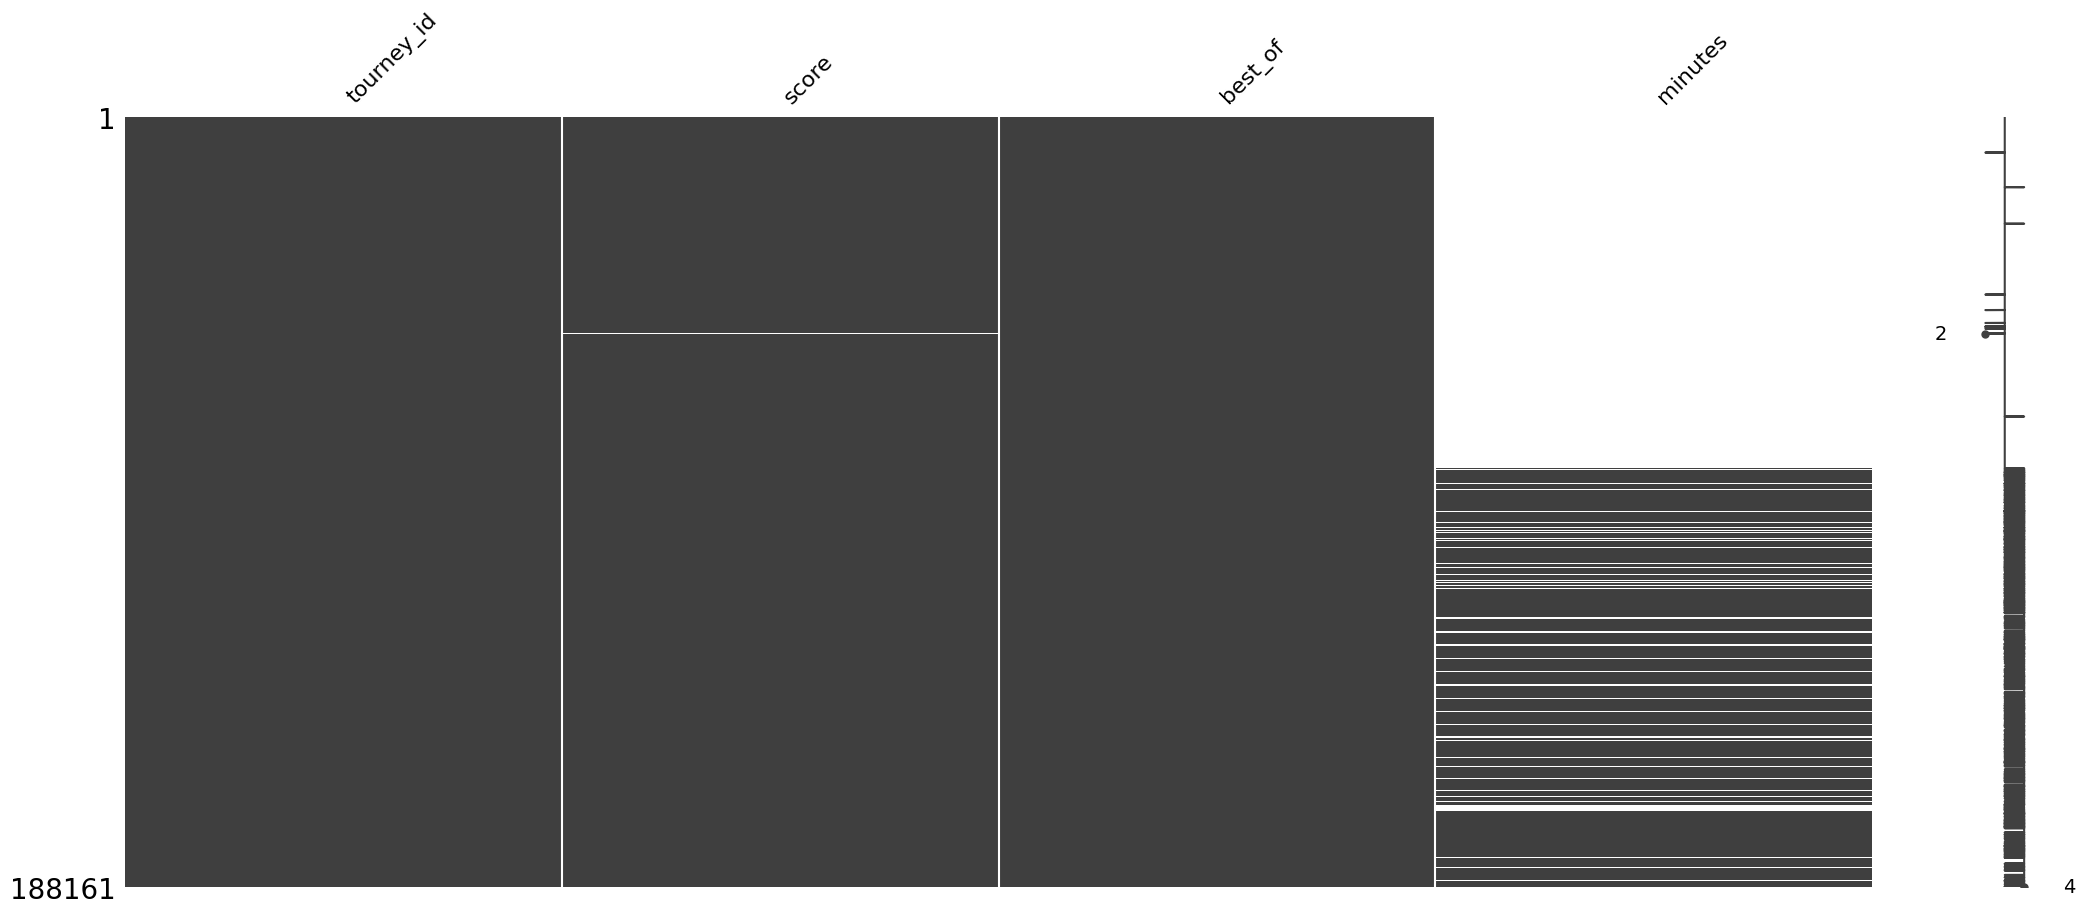

In [9]:
mn.matrix(df_matches[['tourney_id','score','best_of','minutes']])

Es fällt direkt auf, dass die Minuten eines Spieles nicht immer aufgezeichnet wurden.

In [12]:
#Anzahl matches
display(len(df_matches))

188161

In [13]:
#Anzahl matches bei denen die minuten fehlen
fehlend = df_matches['minutes'].isnull().sum()
display(fehlend)

98650

In [14]:
#Anzahl Einträge mit minutes
display(len(df_matches)-fehlend)

89511

Es fällt direkt auf, dass die Minuten eines Spieles nicht immer aufgezeichnet wurden.

Es fehlen mehr als die Hälfte aller Einträge von minutes. Eventuell ist dies aber gar nicht problematisch, da sich Tennis von vor 50 Jahren sicherlich unterscheidet von Tennis von heute und somit etwas relevantere Daten nur verwendet.   
Da nun die relevanten Features bekannt sind, stellt sich nun die Frage was denn nun genau ein "besonders langes" Spiel ist?  
Bei unserer Definition berücksichtigen wir das best_of. Dabei gilt nun:  
Ein Spiel gilt als "besonders" lange, wenn es länger gedauert hat als das 95% Quantil => Also wenn es in die oberen 5% gehört.  
  
Wir vergleichen Ohne Berücksichtigung des best_of und mit Berücksichtigung best_of:


In [17]:
quantile_95 = df_matches['minutes'].quantile(0.95) #quantile methode schließt null-werte bereits aus.
quantile_95

176.0

Ein besonders langes Spiel ohne Rücksicht auf best_of wäre also ein Spiel was länger gedauert hat als ca. 3 Stunden.

In [24]:
#Wir berücksichtigen best_of jetzt
quantile_95_best_of = df_matches.groupby('best_of')['minutes'].quantile(0.95).reset_index()
quantile_95_best_of

,best_of,minutes
0,1,NaN
1,3,152.0
2,5,232.0


Ein besonders langes best_of 3 dauert als mehr als ca. 150 min und ein best_of 5 dauert fast mehr als 4 Stunden. Aber was ist passiert bei best_of 1? Es wird nachgeprüft:

In [21]:
#Entfernen aller Zeilen bei denen keine minuten aufzeichnet wurden.
#Danach prüfen ob es tatsächlich keine best_of 1 mehr gibt
df_matches.dropna(subset= 'minutes')['best_of'].unique()

array([3, 5], dtype=int64)

Tatsächlich, bei jedem best_of 1 wurden keine minutes aufgenommen.

Es sollen nun alle Matches mit einem neuem Feature ausgestattet werden, die besonders lange gingen (Abhängig von best_of).

In [26]:
#Wir geben der Spalte einen besseren namen noch
quantile_95_best_of = quantile_95_best_of.rename(columns={'minutes': 'duration_quantile_95'})
quantile_95_best_of

,best_of,duration_quantile_95
0,1,NaN
1,3,152.0
2,5,232.0


In [30]:
#Hinzufügen des neuen Features duration_quantile_95 in abhängig von best_of
df_merge = pd.merge(df_matches, quantile_95_best_of, on='best_of', how='left')
df_merge.sample(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,duration_quantile_95
95761,1993-321,Stuttgart Outdoor,Clay,56,A,19930719,2,101594,NaN,WC,...,12.0,10.0,8.0,1.0,6.0,114.0,360.0,73.0,545.0,152.0
172669,2017-580,Australian Open,Hard,128,G,20170116,195,104797,NaN,NaN,...,77.0,43.0,27.0,10.0,14.0,117.0,498.0,2.0,11780.0,232.0
136953,2005-414,Hamburg Masters,Clay,64,M,20050509,54,103294,NaN,Q,...,42.0,14.0,14.0,12.0,18.0,68.0,566.0,6.0,2370.0,152.0
117196,1999-308,Munich,Clay,32,A,19990426,15,102318,NaN,NaN,...,11.0,11.0,8.0,4.0,9.0,77.0,619.0,490.0,49.0,152.0
169462,2015-352,Paris Masters,Hard,48,M,20151102,34,104607,5.0,NaN,...,22.0,10.0,9.0,4.0,7.0,5.0,4730.0,10.0,2545.0,152.0


Jetzt kann leicht nach besonders langen Spielen gefiltert werden.

In [33]:
besonders_lange_spiele = df_merge[df_merge['minutes'] > df_merge['duration_quantile_95']]
besonders_lange_spiele

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,duration_quantile_95
85857,1991-339,Adelaide,Hard,32,A,19901231,10,101332,NaN,NaN,...,52.0,25.0,17.0,5.0,9.0,66.0,NaN,228.0,NaN,152.0
85907,1991-354,Wellington,Hard,32,A,19901231,29,101735,3.0,NaN,...,55.0,16.0,16.0,4.0,8.0,32.0,NaN,80.0,NaN,152.0
85981,1991-580,Australian Open,Hard,128,G,19910114,10,101642,NaN,Q,...,78.0,38.0,31.0,16.0,29.0,143.0,241.0,79.0,462.0,232.0
86083,1991-580,Australian Open,Hard,128,G,19910114,112,101414,2.0,NaN,...,77.0,61.0,33.0,15.0,20.0,2.0,3528.0,45.0,641.0,232.0
86096,1991-580,Australian Open,Hard,128,G,19910114,125,100656,3.0,NaN,...,68.0,35.0,27.0,4.0,10.0,3.0,2541.0,1.0,3889.0,232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187946,2022-0605,Tour Finals,Hard,8,F,20221114,292,126203,8.0,NaN,...,50.0,19.0,16.0,3.0,5.0,9.0,2955.0,6.0,3995.0,152.0
187951,2022-0605,Tour Finals,Hard,8,F,20221114,287,104925,7.0,NaN,...,60.0,17.0,16.0,4.0,6.0,8.0,3320.0,5.0,4065.0,152.0
188104,2022-M-DC-2022-WG1-PO-UZB-TUR-01,Davis Cup WG1 PO: UZB vs TUR,Hard,4,D,20220304,1,122109,NaN,NaN,...,42.0,19.0,15.0,3.0,8.0,510.0,62.0,189.0,314.0,152.0
188157,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Davis Cup WG2 PO: GRE vs JAM,Clay,4,D,20220304,5,202065,NaN,NaN,...,40.0,20.0,15.0,4.0,8.0,808.0,23.0,1390.0,4.0,152.0


Es wird nun ein neues Feature hinzufügt, das als Flag für besonders lange Spiele fungiert.

In [34]:
besonders_lange_spiele['very_long_game'] = True

C:\Users\Markus\AppData\Local\Temp\ipykernel_7108\2226633801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  besonders_lange_spiele['very_long_game'] = True


Das neue Feature very_long_game wird nun hinzugefügt zu allen matches.

In [35]:
#Mergen der Tabelle df_matches und besonders_lange_spiele für das neue Feature
df_merge_5 = pd.merge(df_matches,besonders_lange_spiele[['very_long_game']], left_index=True, right_index=True, how='left')
df_merge_5.sample(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,very_long_game
179348,2019-M009,Rome Masters,Clay,64,M,20190513,291,106043,NaN,NaN,...,16.0,14.0,9.0,3.0,6.0,24.0,1440.0,33.0,1275.0,NaN
45683,1979-802,Richmond WCT,Carpet,32,A,19790129,23,100631,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,44.0,NaN,10.0,NaN,NaN
24759,1974-583,Manchester,Grass,16,A,19740603,284,100201,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,63.0,0.0,NaN,NaN,NaN
147722,2008-560,US Open,Hard,128,G,20080825,95,103285,28.0,NaN,...,56.0,20.0,20.0,5.0,9.0,30.0,1006.0,87.0,505.0,NaN
6451,1969-9277,Curacao,Hard,16,A,19690224,295,100128,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Alle Matches die NaN Werte haben für das neue Feature very_long_game werden sinnvollerweise mit False gefüllt.

In [36]:
df_merge_5['very_long_game'] = df_merge_5['very_long_game'].fillna(False)

Wir wissen nun alle Matches mithilfe eines Flags die besonders lang waren. Für die Aufgabenstellung ist aber auch noch das Datum für die Sortierung später wichtig. Dieses muss noch das richtige Type erhalten.

In [39]:
#Tourney_date type ändern
df_merge_5['tourney_date'] = pd.to_datetime(df_merge_5['tourney_date'], format='%Y%m%d')
df_merge_5 = df_merge_5.sort_values(['winner_id', 'tourney_date'])

In [38]:
df_merge_5.head(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,very_long_game
1694,1968-3940,Barranquilla,Clay,32,A,1968-03-04,274,100001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6204,1969-6818,St. Petersburg,Clay,64,A,1969-03-17,262,100001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5583,1969-2047,Jacksonville,Clay,32,A,1969-04-02,274,100001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9273,1970-2047,Jacksonville,Clay,32,A,1970-03-25,274,100001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2724,1968-6811,Los Angeles NTL,Carpet,16,A,1968-07-17,295,100002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Für die Fragestellung brauchen wir nun die Spieler. Wir müssen später nach Spieler gruppieren können und für jeden Spieler alle Matches haben an denen diese Teilgenommen haben.  
Die neue Tabelle sollte also doppelt so viele Einträge haben wie die matches.

In [42]:
#Laden der Spieler
df_players = pd.read_csv("data/atp_players_till_2022.csv")

In [43]:
df_players.sample(5)

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
48895,202243,Annei,Laska,U,20000113.0,BLR,NaN,NaN
33580,133596,Javier,Aznar Martinez,U,19980906.0,ESP,NaN,NaN
42300,142316,Stonar,Coleman,U,19781225.0,USA,NaN,NaN
2703,102704,Markus,Tanner,R,19760105.0,SUI,NaN,NaN
23685,123701,Quincy,Adjei Darko,U,19850512.0,GHA,NaN,NaN


merged_winner_df wird ein DataFrame, bei dem die winner_id und die player_id gleich sein werden.

In [47]:
merged_winner_df = pd.merge(df_merge_5, df_players, left_on='winner_id', right_on='player_id', how='left')
merged_winner_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank_points,very_long_game,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,1968-3940,Barranquilla,Clay,32,A,1968-03-04,274,100001,NaN,NaN,...,NaN,False,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
1,1969-6818,St. Petersburg,Clay,64,A,1969-03-17,262,100001,NaN,NaN,...,NaN,False,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
2,1969-2047,Jacksonville,Clay,32,A,1969-04-02,274,100001,NaN,NaN,...,NaN,False,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
3,1970-2047,Jacksonville,Clay,32,A,1970-03-25,274,100001,NaN,NaN,...,NaN,False,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
4,1968-6811,Los Angeles NTL,Carpet,16,A,1968-07-17,295,100002,NaN,NaN,...,NaN,False,100002,Pancho,Segura,R,19210620.0,ECU,168.0,Q54581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188156,1972-7308,Adelaide,Grass,64,A,1972-01-17,256,211376,NaN,NaN,...,NaN,False,211376,Richard,Garey,U,NaN,AUS,NaN,NaN
188157,1972-7308,Adelaide,Grass,64,A,1972-01-17,242,211377,NaN,NaN,...,NaN,False,211377,Keith,Simpson,U,NaN,AUS,NaN,NaN
188158,1970-319,Kitzbuehel,Clay,64,A,1970-08-09,250,211421,NaN,NaN,...,NaN,False,211421,Peter,Popovic,U,NaN,UNK,NaN,NaN
188159,1970-6818,St. Petersburg,Clay,64,A,1970-04-06,251,211423,NaN,NaN,...,NaN,False,211423,John,Solow,U,NaN,USA,NaN,NaN


Es wird ein neues Feature hinzugefügt, damit später leichter herausgefunden werden kann ob player_id gewonnen hatte.

In [48]:
merged_winner_df['player_id_won'] = True

In [50]:
#Nur die relevanten Features zeigen
merged_winner_df[['player_id', 'winner_id','loser_id','tourney_id','tourney_date','match_num','very_long_game','player_id_won']].sample(5)

,player_id,winner_id,loser_id,tourney_id,tourney_date,match_num,very_long_game,player_id_won
82501,101298,101298,100631,1988-301,1988-01-04,12,False,True
19723,100133,100133,100377,1975-254,1975-11-17,282,False,True
100092,101843,101843,101772,1994-224,1994-08-22,1,False,True
173257,105807,105807,111202,2018-6242,2018-08-20,294,False,True
29099,100231,100231,100247,1974-419,1974-08-05,17,False,True


Analog werden nun auch die Matches genommen, bei dem player_id verloren hatte.

In [52]:
merged_loser_df = pd.merge(df_merge_5, df_players, left_on='loser_id', right_on='player_id', how='left')
merged_loser_df['player_id_won'] = False
merged_loser_df[['player_id', 'winner_id','loser_id','tourney_id','tourney_date','match_num','very_long_game','player_id_won']].sample(5)

,player_id,winner_id,loser_id,tourney_id,tourney_date,match_num,very_long_game,player_id_won
184717,144895,126774,144895,2018-0425,2018-04-23,252,False,False
99864,101264,101843,101264,1990-319,1990-07-30,29,False,False
183893,106210,126094,106210,2022-0495,2022-02-21,300,False,False
49974,100416,100446,100416,1980-315,1980-07-07,285,False,False
35858,100186,100282,100186,1973-419,1973-08-13,28,False,False


Jetzt werden die Tabellen merged_winner_df und merged_loser_df verschmolzen. Der neue DataFrame beinhaltet alle Spieler mit jeweils allen Spielen an diese teilgenommen hatten.

In [53]:
merged_all = pd.concat([merged_winner_df[['player_id', 'winner_id','loser_id','tourney_id','tourney_date','match_num','very_long_game','player_id_won']],
                        merged_loser_df[['player_id', 'winner_id','loser_id','tourney_id','tourney_date','match_num','very_long_game','player_id_won']]]).reset_index(drop=True)

Prüfen der neuen Tabelle und sortieren Best möglichst nach der Reihenfolge wie es mit den gegebenen Features möglich ist.

In [55]:
merged_all.sort_values(by=['player_id', 'tourney_date','match_num'], inplace=True)
merged_all

,player_id,winner_id,loser_id,tourney_id,tourney_date,match_num,very_long_game,player_id_won
0,100001,100001,100039,1968-3940,1968-03-04,274,False,True
195830,100001,100073,100001,1968-3940,1968-03-04,292,False,False
369431,100001,110268,100001,1968-410,1968-04-15,267,False,False
1,100001,100001,209609,1969-6818,1969-03-17,262,False,True
204327,100001,100119,100001,1969-6818,1969-03-17,273,False,False
...,...,...,...,...,...,...,...,...
208532,211801,100139,211801,1968-319,1968-08-20,269,False,False
369188,211802,110005,211802,1968-319,1968-08-20,268,False,False
210686,211803,100161,211803,1968-319,1968-08-20,265,False,False
375859,211804,208990,211804,1968-319,1968-08-20,255,False,False


Das DataFrame sieht gut aus, die Zeilenanzahl ist auch wie erwartet doppelt so groß.

Für die Aufgabenstellung ist wichtig zu wissen, ob ein Spiel nach einem langen Spiel stattgefunden hatte. Wir fügen ein neues Feature hinzu und nutzen dazu das erstelle Feature very_long_game.

In [58]:
merged_all['previous_match_was_long'] = merged_all.groupby('player_id')['very_long_game'].shift(fill_value=False)

In [61]:
merged_all.sample(5)

,player_id,winner_id,loser_id,tourney_id,tourney_date,match_num,very_long_game,player_id_won,previous_match_was_long
285115,101821,101746,101821,1997-580,1997-01-13,71,False,False,False
229925,100261,100326,100261,1980-338,1980-12-15,53,False,False,False
237901,100397,100443,100397,1980-206,1980-03-03,27,False,False,False
305157,101334,102563,101334,1997-568,1997-03-17,8,False,False,False
28023,100220,100220,100098,1973-379,1973-10-28,30,False,True,False


Jetzt sind die nötigen Features vorhanden die zur Auswertung nötig sind. Es muss jetzt nur noch gruppiert werden nach previus_match_was_long und mithile von player_id_won können wir die Häufigkeit ausrechnen.

In [64]:
result = merged_all.groupby('previous_match_was_long')['player_id_won'].mean() * 100

In [70]:
#Auf 2 nachkommastellen runden
result = result.round(2)
result

previous_match_was_long
False    50.01
True     49.77
Name: player_id_won, dtype: float64

Es scheint keinen Unterschied zu machen ob ein Spiel vorher sehr lange gewesen ist, wobei wir einiges noch beachten müssen:  
Wir können leider nicht berücksichtigen, wie viele Tage zwischen den Matches lagen. Es ist nur das Startdatum des Turnieres bekannt und die match_num für die Reihenfolge (Keine direkten Zeitlichen Hinweise) Die Fragestellung lässt sich also nicht wirklich gut beantworten mit den gegebenen Daten.  
Das Ergebnis wird mit einem Sunburst dargestellt.


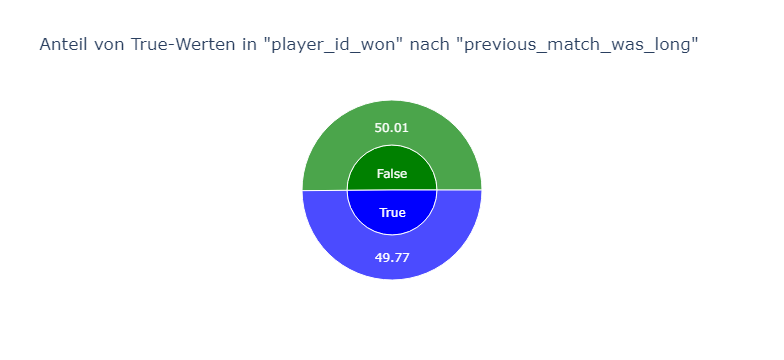

In [72]:
result_df = result.reset_index()
# Sunburst-Diagramm mit Plotly Express erstellen
fig = px.sunburst(result_df, path=['previous_match_was_long','player_id_won'], values='player_id_won', 
                  title= 'Anteil von True-Werten in "player_id_won" nach "previous_match_was_long"',
                  color_discrete_sequence=['green', 'blue'])

# Zeige das Diagramm an
fig.show()